Importowane biblioteki i pliki. Plik "titanic_prep.csv" jest plikiem wygenerowanym na podstawie pierwszego zadania oraz zostanie załączony do tego rozwiązania. Dodatkowo kodowanie klas wygląda w następujący sposób

Embarked: {0: 'C', 1: 'Q', 2: 'S'}

CGroup{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'T', 8: 'U'}

In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, precision_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import product



data = pd.read_csv('titanic_prep.csv')
data.info()
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   isMale       891 non-null    int64  
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   CGroup       891 non-null    int64  
 9   Embarked     891 non-null    int64  
 10  isAlone      891 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 76.7 KB
   PassengerId  Survived  Pclass  isMale  Age  SibSp  Parch     Fare  CGroup  \
0            1         0       3       1   22      1      0   7.2500       8   
1            2         1       1       0   38      1      0  71.2833       2   
2            3         1       3       0   26      0     

**Obserwacje z zadania 1:**

Obserwację pokazują, że czynnikami znaczącymi w przetrwaniu są przede wszystkim wiek oraz płeć. Dodatkowe czynniki to klasa pasażera, połączona z nią cena, rozmiar rodziny, fakt czy osoba podróżowała sama oraz w pewnym stopniu pokład na którym się znajdowała (lub brak informacji o tym pokładzie). Bez znaczenia wydają się dane przedstawione w kolumnach [Name] oraz [Ticket]. Kolumna [Embarked] także miała pewien wpływ na szansę przeżycia pasażera, chociaż to jest najprawdopodobniej wynik tego, że bogatsi ludzie częściej wypływali z jednego portu.

**Podział danych na dane testowe i treningowe**

In [315]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("Survived",axis=1), data['Survived'], test_size=0.8, random_state=42,shuffle=True)

data = data.drop('PassengerId',axis=1) # Getting rid of id column

Skalowanie

Powinno poprawić wyniki ponieważ usuwa sytuacje w których duże wartości liczbowe dominują nad tymi mniejszymi.

In [316]:

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
print(X_train[0:5] )

[[ 1.25155384  0.83212287  0.72205784  0.9683292  -0.4512865  -0.39241679
  -0.61097774  0.55412235  0.54427621  0.74015275]
 [ 0.80074644 -1.51895445  0.72205784  1.56710746  0.38547389 -0.39241679
   1.32042187 -1.44251285 -2.11000228 -1.35107247]
 [ 1.22434995 -0.34341579 -1.38493061  1.56710746  0.38547389  2.57993167
   0.99495628  0.55412235  0.54427621 -1.35107247]
 [ 0.45486834 -1.51895445 -1.38493061  1.56710746  0.38547389 -0.39241679
   0.29014895 -2.64049397 -2.11000228 -1.35107247]
 [ 1.59743194  0.83212287  0.72205784 -2.19664158  2.89575505  2.57993167
   0.05914419  0.55412235  0.54427621 -1.35107247]]


**Baseline Classifier**

Wyniki zostaną porównane z testowanymi modelami i ich iteracjami w zależności od hiperparametrów.

In [317]:
dummy_clsf = DummyClassifier(strategy='uniform')
dummy_clsf.fit(X_train, y_train)
y_pred = dummy_clsf.predict(X_test)


print(f'Baseline Classifier accuracy: {dummy_clsf.score(X_test, y_test)} \n')
print(f'ROC AUC score: {roc_auc_score(y_test,y_pred)}\n')
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


Baseline Classifier accuracy: 0.5049088359046283 

ROC AUC score: 0.49497814062862255

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       436
           1       0.38      0.47      0.42       277

    accuracy                           0.50       713
   macro avg       0.50      0.49      0.49       713
weighted avg       0.52      0.50      0.51       713



array([[227, 209],
       [147, 130]])

**Modele:**

Zdecydowałem się użyć KNN oraz Random Forest, więc to te modele będą testowane z różnymi hiperparametrami. Dla każdego modelu dwa wybrane parametry zostawały zmieniane, oraz wyniki wpływu tej zmiany został umieszczony na grafie.

In [318]:
# Funkcja przyjmie model, dane treningowe oraz testowe i hiperparametry
# Na podstawie przyjętych danych stw
def evaluate_classifier(clf, param_grid, X_train, y_train, X_test, y_test, clf_name="Classifier"):

    results = []

    keys, values = zip(*param_grid.items())
    param1, param2 = keys
    values1, values2 = values

    for combination in product(*values):
        params = dict(zip(keys, combination))
        clf.set_params(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        results.append({
            "classifier": clf_name,
            "param1": params[param1],
            "param2": params[param2],
            "accuracy": clf.score(X_test, y_test),
            "roc_auc": roc_auc_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred)
        })

    df_results = pd.DataFrame(results)
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    sns.lineplot(
            x="param1", y="accuracy", hue="param2",
            data=df_results, marker="o"
        )
    plt.grid()
    plt.xlabel(param1)
    plt.legend(title=param2)
    plt.title(f"{clf_name} - Accuracy")

    # ROC AUC
    plt.subplot(1,2,2)
    sns.lineplot(
            x="param1", y="roc_auc", hue="param2",
            data=df_results, marker="o"
        )
    plt.grid()
    plt.xlabel(param1)
    plt.legend(title=param2)
    plt.title(f"{clf_name} - ROC AUC")

    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12,5))
    # Precision
    plt.subplot(1,2,1)
    sns.lineplot(
            x="param1", y="precision", hue="param2",
            data=df_results, marker="o"
        )
    plt.grid()
    plt.xlabel(param1)
    plt.legend(title=param2)
    plt.title(f"{clf_name} - Precision")

    # Recall
    plt.subplot(1,2,2)
    sns.lineplot(
            x="param1", y="recall", hue="param2",
            data=df_results, marker="o"
        )
    plt.grid()
    plt.xlabel(param1)
    plt.legend(title=param2)
    plt.title(f"{clf_name} - Recall")

    plt.tight_layout()
    plt.show()





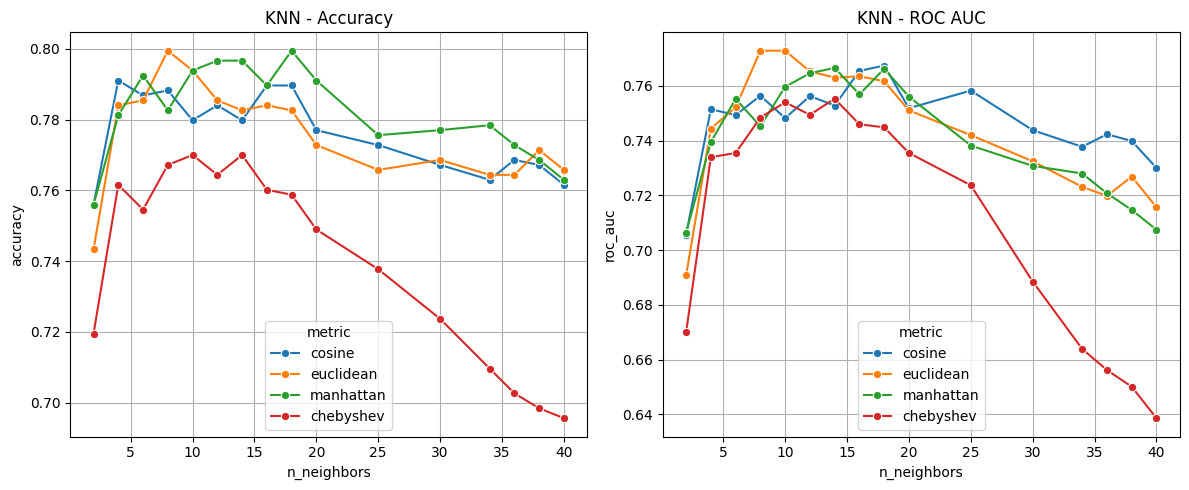

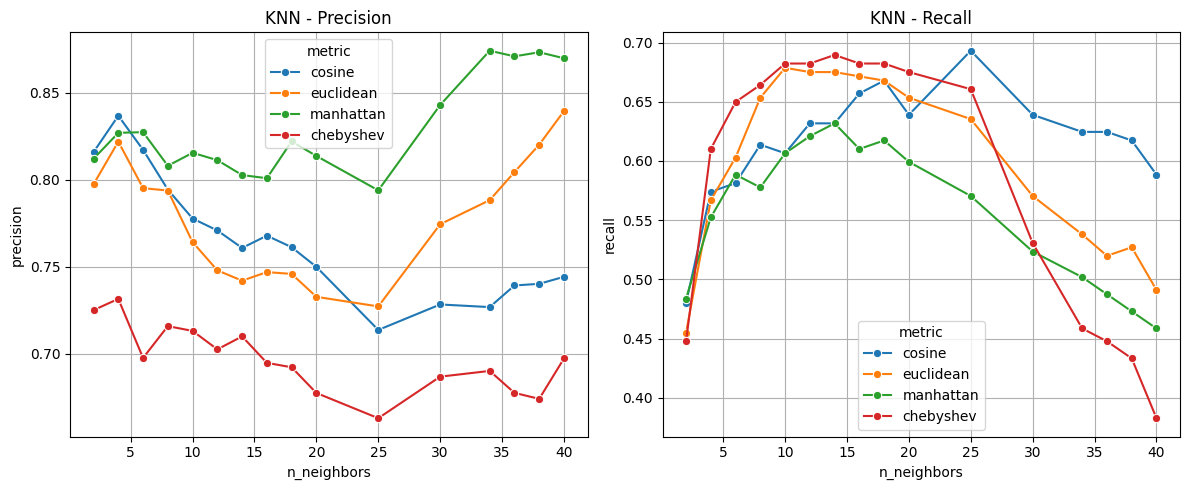

In [319]:
param_grid = {
    "n_neighbors": [2,4,6,8,10,12,14,16,18,20,25,30,34,36,38,40],
    "metric": ["cosine", "euclidean","manhattan","chebyshev"]
}
evaluate_classifier(
    KNeighborsClassifier(),
    param_grid,
    X_train, y_train, X_test, y_test,
    clf_name="KNN"
)

Ok tak jak widzimy powyżej największę róznicę obecne są w statystykach Precision oraz Recall. Największa różnica pomiędzy Max oraz Min to około 0.16 dla Precision oraz 0.12 dla Recall. Wszystkie statystyki poza Precision zaczynają spadać dla n_neighbors powyżej 40. Zwiekszając przedział zobaczylibyśmy, że dla precision ta wartośc to około 100. Precyzja ma zauważalnie inny trend niż reszta wyników. Dla nich wysokie wyniki zostają osiągnięte w przedziałach 5-25. Jako, że przewidujemy tutaj czy ktoś przeżył ciężko jest uznać którąś ze statystyk za znacznie ważniejszą niż inna.

Random Forest

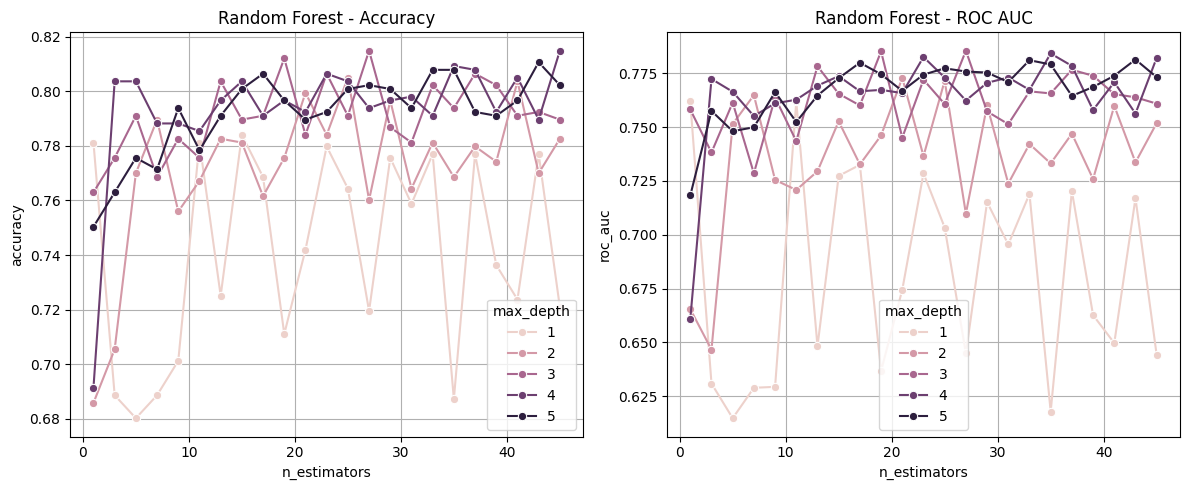

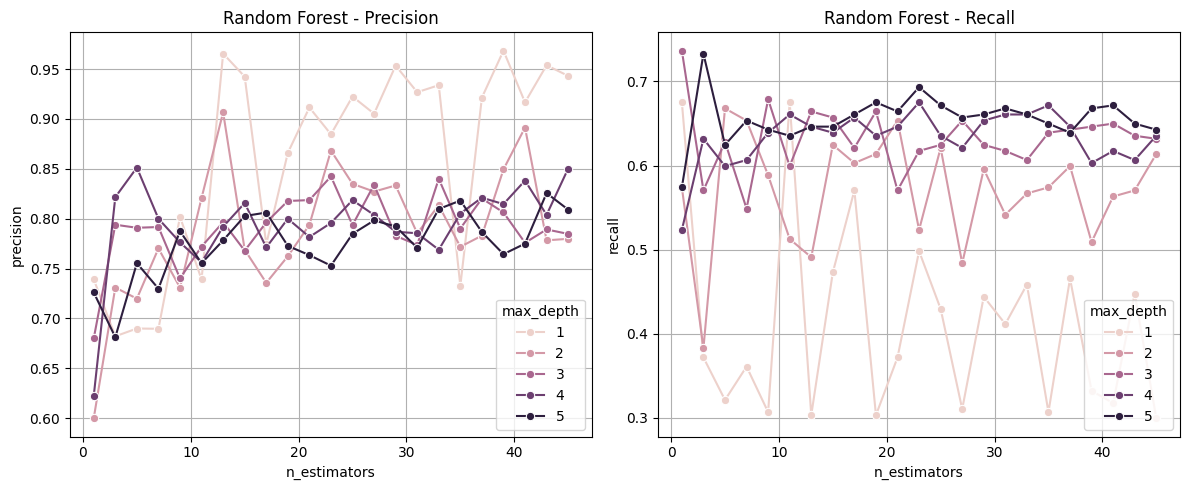

In [320]:
param_grid = {
    "n_estimators": [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45],
    "max_depth": [1,2,3,4,5]
}
evaluate_classifier(
    RandomForestClassifier(),
    param_grid,
    X_train, y_train, X_test, y_test,
    clf_name="Random Forest")

W tym przypadku trendy są dużo cięższe do zauważenia. Większy max_depth oznacza lepsze wyniki dla każdej statystyki poza Precision, chociaż różnice zmniejszają się dla coraz większych wartości. Parametr n_estimators nie wydaje się wpływać w żaden sposób przypominający trend na statystyki poza faktem że dla niektórych wartości zauważalne są ostre zmiany wyników obecne w każdym z modeli.

**Wnioski**

Oba modele osiągnęły znacznie lepsze wyniki niż baseline (byłoby to dość niezręczne, gdyby tak nie było). Spośród nich lepszy okazał się Random Forest, który uzyskał wyższe wartości w statystykach Accuracy, ROC AUC oraz Recall, a jednocześnie znacząco przewyższył drugi model pod względem Precision.